## Fruits-360

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from cifar10_models.resnet import resnet18 as resnet18_cifar10

In [2]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='./data/fruits-360/Training', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./data/fruits-360/Test', transform=test_transform)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

70491 23619
torch.Size([1, 100, 100])


In [3]:
train_images_list, train_labels_list = [], []

for images, labels in DataLoader(train_dataset, batch_size=128):
    train_images_list.append(images.numpy())
    train_labels_list.append(labels.numpy())

train_np = np.concatenate(train_images_list, axis=0).transpose(0, 2, 3, 1).squeeze(axis=-1)
train_labels = np.concatenate(train_labels_list, axis=0)


test_images_list, test_labels_list = [], []

for images, labels in DataLoader(test_dataset, batch_size=128):
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

test_np = np.concatenate(test_images_list, axis=0).transpose(0, 2, 3, 1).squeeze(axis=-1)
test_labels = np.concatenate(test_labels_list, axis=0)

print(train_np.shape, train_labels.shape)
print(test_np.shape, test_labels.shape)
print(len(np.unique(train_labels)))

# ~1m 20s

(70491, 100, 100) (70491,)
(23619, 100, 100) (23619,)
141


## Feature Extraction

In [164]:
def extract_hog_features(images):
    hog_features = []
    
    for img in images:
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=False)
        hog_features.append(features)
        
    return np.array(hog_features)

train_hog = extract_hog_features(train_np)
test_hog = extract_hog_features(test_np)

print(train_hog.shape)

# ~5m 11s

(70491, 4356)


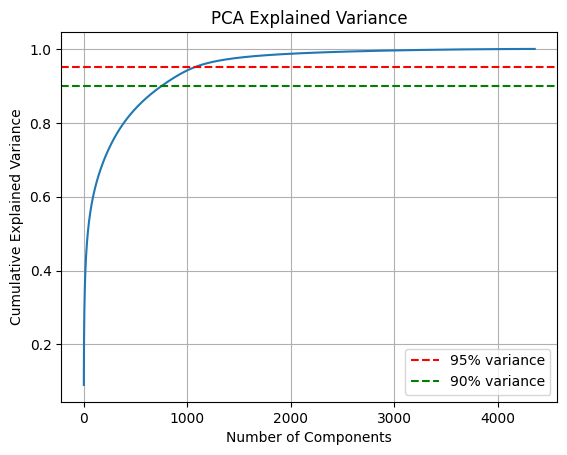

Number of components for 95% variance: 1067
Number of components for 90% variance: 754


In [165]:
pca = PCA()
pca.fit(train_hog)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")

# ~1m 20s

In [166]:
n_components = n_components_95
pca = PCA(n_components=n_components)

train_pca = pca.fit_transform(train_hog)
test_pca = pca.transform(test_hog)

print(train_pca.shape, test_pca.shape)

# ~33s

(70491, 1067) (23619, 1067)


In [167]:
scaler = StandardScaler()
train_pca_scaled = scaler.fit_transform(train_pca)
test_pca_scaled = scaler.transform(test_pca)

print(f"Shape before selection: {train_pca_scaled.shape}")

# ~0.9s

Shape before selection: (70491, 1067)


In [168]:
percentile = 12
selector_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
train_selected_percentile = selector_percentile.fit_transform(train_pca_scaled, train_labels)
test_selected_percentile = selector_percentile.transform(test_pca_scaled)

print(f"Shape after Select Percentile: {train_selected_percentile.shape, test_selected_percentile.shape}")

Shape after Select Percentile: ((70491, 128), (23619, 128))


In [13]:
def plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, title):

    max_train_accuracy = max(train_accuracies)
    max_test_accuracy = max(test_accuracies)
    max_train_epoch = train_accuracies.index(max_train_accuracy)
    max_test_epoch = test_accuracies.index(max_test_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='g')
    plt.plot(test_losses, label="Test Loss", color='m')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({title})")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color='g')
    plt.plot(test_accuracies, label="Test Accuracy", color='m')
    plt.scatter(max_train_epoch, max_train_accuracy, color='g', label=f"Max Train Accuracy: {max_train_accuracy:.4f}", zorder=5)
    plt.scatter(max_test_epoch, max_test_accuracy, color='m', label=f"Max Test Accuracy: {max_test_accuracy:.4f}", zorder=5)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves ({title})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [170]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device='cpu'):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

## MLP over extracted features

In [171]:
X_train = torch.tensor(train_selected_percentile, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_selected_percentile, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [172]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )
    
    def forward(self, x):
        return self.model(x)
    
input_size = train_selected_percentile.shape[1]
num_classes = len(np.unique(train_labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [173]:
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 493.34it/s]


Epoch 1/30, Train Loss: 1.9677, Test Loss: 1.0367, Train Acc: 0.5357, Test Acc: 0.7428


Epoch 2/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 426.92it/s]


Epoch 2/30, Train Loss: 0.7165, Test Loss: 0.8278, Train Acc: 0.7864, Test Acc: 0.7918


Epoch 3/30 Testing: 100%|██████████| 370/370 [00:01<00:00, 307.88it/s]


Epoch 3/30, Train Loss: 0.5480, Test Loss: 0.8106, Train Acc: 0.8305, Test Acc: 0.8064


Epoch 4/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 452.26it/s]


Epoch 4/30, Train Loss: 0.4701, Test Loss: 0.7564, Train Acc: 0.8524, Test Acc: 0.8166


Epoch 5/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 443.22it/s]


Epoch 5/30, Train Loss: 0.4184, Test Loss: 0.7710, Train Acc: 0.8683, Test Acc: 0.8232


Epoch 6/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 461.43it/s]


Epoch 6/30, Train Loss: 0.3866, Test Loss: 0.7360, Train Acc: 0.8750, Test Acc: 0.8274


Epoch 7/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 437.49it/s]


Epoch 7/30, Train Loss: 0.3601, Test Loss: 0.7364, Train Acc: 0.8848, Test Acc: 0.8340


Epoch 8/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 450.73it/s]


Epoch 8/30, Train Loss: 0.3460, Test Loss: 0.7732, Train Acc: 0.8890, Test Acc: 0.8320


Epoch 9/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 389.70it/s]


Epoch 9/30, Train Loss: 0.3287, Test Loss: 0.7334, Train Acc: 0.8950, Test Acc: 0.8371


Epoch 10/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 465.48it/s]


Epoch 10/30, Train Loss: 0.3119, Test Loss: 0.7162, Train Acc: 0.8989, Test Acc: 0.8426


Epoch 11/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 420.15it/s]


Epoch 11/30, Train Loss: 0.3062, Test Loss: 0.6909, Train Acc: 0.9027, Test Acc: 0.8486


Epoch 12/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 461.97it/s]


Epoch 12/30, Train Loss: 0.2900, Test Loss: 0.7159, Train Acc: 0.9053, Test Acc: 0.8456


Epoch 13/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 468.37it/s]


Epoch 13/30, Train Loss: 0.2867, Test Loss: 0.7255, Train Acc: 0.9068, Test Acc: 0.8464


Epoch 14/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 457.45it/s]


Epoch 14/30, Train Loss: 0.2813, Test Loss: 0.7384, Train Acc: 0.9100, Test Acc: 0.8466


Epoch 15/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 450.76it/s]


Epoch 15/30, Train Loss: 0.2698, Test Loss: 0.7108, Train Acc: 0.9132, Test Acc: 0.8500


Epoch 16/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 469.20it/s]


Epoch 16/30, Train Loss: 0.2651, Test Loss: 0.7390, Train Acc: 0.9133, Test Acc: 0.8483


Epoch 17/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 469.57it/s]


Epoch 17/30, Train Loss: 0.2595, Test Loss: 0.7418, Train Acc: 0.9158, Test Acc: 0.8487


Epoch 18/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 463.74it/s]


Epoch 18/30, Train Loss: 0.2521, Test Loss: 0.7135, Train Acc: 0.9169, Test Acc: 0.8499


Epoch 19/30 Testing: 100%|██████████| 370/370 [00:01<00:00, 310.32it/s]


Epoch 19/30, Train Loss: 0.2454, Test Loss: 0.7263, Train Acc: 0.9211, Test Acc: 0.8499


Epoch 20/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 472.34it/s]


Epoch 20/30, Train Loss: 0.2436, Test Loss: 0.6962, Train Acc: 0.9201, Test Acc: 0.8555


Epoch 21/30 Testing: 100%|██████████| 370/370 [00:01<00:00, 360.53it/s]


Epoch 21/30, Train Loss: 0.2391, Test Loss: 0.7175, Train Acc: 0.9218, Test Acc: 0.8556


Epoch 22/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 450.78it/s]


Epoch 22/30, Train Loss: 0.2329, Test Loss: 0.7209, Train Acc: 0.9236, Test Acc: 0.8538


Epoch 23/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 470.96it/s]


Epoch 23/30, Train Loss: 0.2285, Test Loss: 0.7122, Train Acc: 0.9258, Test Acc: 0.8569


Epoch 24/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 479.27it/s]


Epoch 24/30, Train Loss: 0.2328, Test Loss: 0.7022, Train Acc: 0.9247, Test Acc: 0.8594


Epoch 25/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 488.21it/s]


Epoch 25/30, Train Loss: 0.2225, Test Loss: 0.7255, Train Acc: 0.9278, Test Acc: 0.8566


Epoch 26/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 508.90it/s]


Epoch 26/30, Train Loss: 0.2238, Test Loss: 0.7207, Train Acc: 0.9276, Test Acc: 0.8553


Epoch 27/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 526.23it/s]


Epoch 27/30, Train Loss: 0.2178, Test Loss: 0.7338, Train Acc: 0.9288, Test Acc: 0.8560


Epoch 28/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 515.26it/s]


Epoch 28/30, Train Loss: 0.2209, Test Loss: 0.7236, Train Acc: 0.9286, Test Acc: 0.8584


Epoch 29/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 496.78it/s]


Epoch 29/30, Train Loss: 0.2090, Test Loss: 0.7347, Train Acc: 0.9311, Test Acc: 0.8572


Epoch 30/30 Testing: 100%|██████████| 370/370 [00:00<00:00, 450.18it/s]

Epoch 30/30, Train Loss: 0.2110, Test Loss: 0.7215, Train Acc: 0.9303, Test Acc: 0.8609


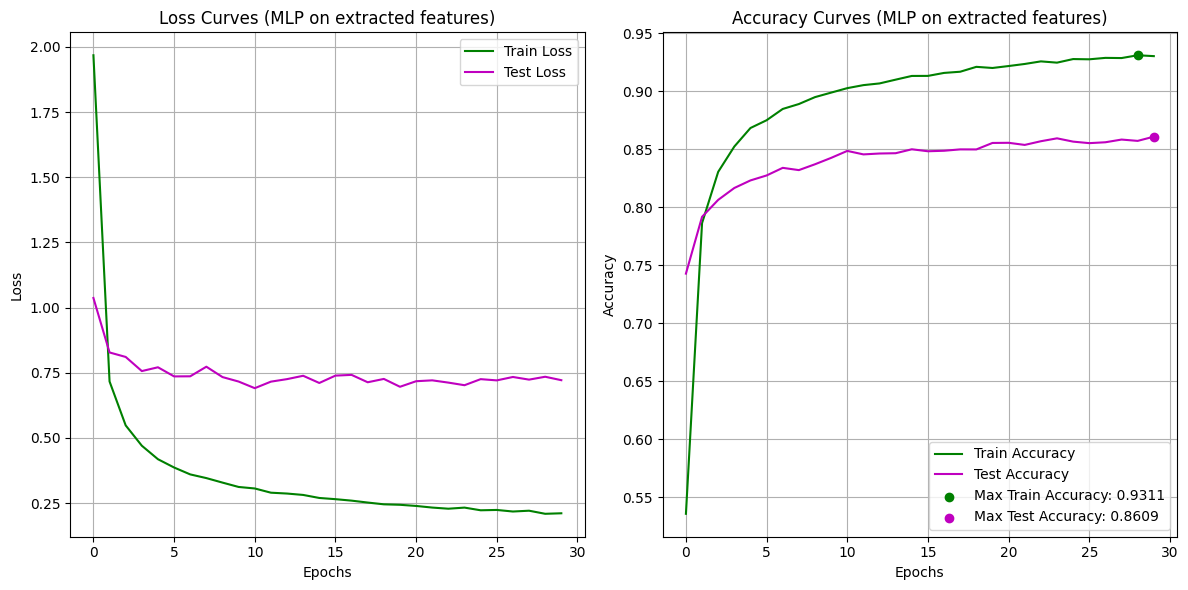

In [174]:
plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, "MLP on extracted features")

## MLP directly on images 

In [175]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))

])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.ImageFolder(root='./data/fruits-360/Training', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./data/fruits-360/Test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

70491 23619
torch.Size([3072])


In [179]:
class MLPImage(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPImage, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.model(x)


input_size = 3 * 32 * 32
num_classes = len(np.unique(train_labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPImage(input_size, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [180]:
num_epochs = 30
train_losses_mlp, test_losses_mlp, train_accuracies_mlp, test_accuracies_mlp = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 31.02it/s]


Epoch 1/30, Train Loss: 2.0716, Test Loss: 0.9251, Train Acc: 0.4486, Test Acc: 0.7653


Epoch 2/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.51it/s]


Epoch 2/30, Train Loss: 0.6153, Test Loss: 0.6145, Train Acc: 0.8095, Test Acc: 0.8451


Epoch 3/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.30it/s]


Epoch 3/30, Train Loss: 0.3621, Test Loss: 0.4413, Train Acc: 0.8850, Test Acc: 0.8789


Epoch 4/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.15it/s]


Epoch 4/30, Train Loss: 0.2550, Test Loss: 0.4018, Train Acc: 0.9178, Test Acc: 0.8926


Epoch 5/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 31.09it/s]


Epoch 5/30, Train Loss: 0.1995, Test Loss: 0.3587, Train Acc: 0.9363, Test Acc: 0.9045


Epoch 6/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.24it/s]


Epoch 6/30, Train Loss: 0.1656, Test Loss: 0.3403, Train Acc: 0.9447, Test Acc: 0.9124


Epoch 7/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.33it/s]


Epoch 7/30, Train Loss: 0.1410, Test Loss: 0.3496, Train Acc: 0.9530, Test Acc: 0.9072


Epoch 8/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 28.65it/s]


Epoch 8/30, Train Loss: 0.1230, Test Loss: 0.3456, Train Acc: 0.9593, Test Acc: 0.9230


Epoch 9/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.62it/s]


Epoch 9/30, Train Loss: 0.1115, Test Loss: 0.4218, Train Acc: 0.9621, Test Acc: 0.9025


Epoch 10/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 31.94it/s]


Epoch 10/30, Train Loss: 0.1034, Test Loss: 0.3581, Train Acc: 0.9646, Test Acc: 0.9110


Epoch 11/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.27it/s]


Epoch 11/30, Train Loss: 0.0958, Test Loss: 0.3312, Train Acc: 0.9668, Test Acc: 0.9297


Epoch 12/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.86it/s]


Epoch 12/30, Train Loss: 0.0906, Test Loss: 0.3452, Train Acc: 0.9683, Test Acc: 0.9180


Epoch 13/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.67it/s]


Epoch 13/30, Train Loss: 0.0855, Test Loss: 0.3542, Train Acc: 0.9704, Test Acc: 0.9243


Epoch 14/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.33it/s]


Epoch 14/30, Train Loss: 0.0773, Test Loss: 0.3762, Train Acc: 0.9730, Test Acc: 0.9269


Epoch 15/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 31.35it/s]


Epoch 15/30, Train Loss: 0.0763, Test Loss: 0.4315, Train Acc: 0.9740, Test Acc: 0.9096


Epoch 16/30 Testing: 100%|██████████| 370/370 [00:11<00:00, 30.97it/s]


Epoch 16/30, Train Loss: 0.0699, Test Loss: 0.4482, Train Acc: 0.9763, Test Acc: 0.9014


Epoch 17/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.94it/s]


Epoch 17/30, Train Loss: 0.0692, Test Loss: 0.3326, Train Acc: 0.9759, Test Acc: 0.9399


Epoch 18/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.54it/s]


Epoch 18/30, Train Loss: 0.0636, Test Loss: 0.3552, Train Acc: 0.9778, Test Acc: 0.9280


Epoch 19/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.83it/s]


Epoch 19/30, Train Loss: 0.0631, Test Loss: 0.3461, Train Acc: 0.9777, Test Acc: 0.9381


Epoch 20/30 Testing: 100%|██████████| 370/370 [00:14<00:00, 26.14it/s]


Epoch 20/30, Train Loss: 0.0629, Test Loss: 0.3797, Train Acc: 0.9778, Test Acc: 0.9330


Epoch 21/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.03it/s]


Epoch 21/30, Train Loss: 0.0609, Test Loss: 0.3400, Train Acc: 0.9789, Test Acc: 0.9398


Epoch 22/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 28.68it/s]


Epoch 22/30, Train Loss: 0.0560, Test Loss: 0.4182, Train Acc: 0.9807, Test Acc: 0.9279


Epoch 23/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.58it/s]


Epoch 23/30, Train Loss: 0.0537, Test Loss: 0.4092, Train Acc: 0.9808, Test Acc: 0.9390


Epoch 24/30 Testing: 100%|██████████| 370/370 [00:13<00:00, 27.36it/s]


Epoch 24/30, Train Loss: 0.0595, Test Loss: 0.3626, Train Acc: 0.9791, Test Acc: 0.9423


Epoch 25/30 Testing: 100%|██████████| 370/370 [00:14<00:00, 26.42it/s]


Epoch 25/30, Train Loss: 0.0509, Test Loss: 0.3837, Train Acc: 0.9826, Test Acc: 0.9312


Epoch 26/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.82it/s]


Epoch 26/30, Train Loss: 0.0554, Test Loss: 0.4151, Train Acc: 0.9805, Test Acc: 0.9369


Epoch 27/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.91it/s]


Epoch 27/30, Train Loss: 0.0524, Test Loss: 0.3428, Train Acc: 0.9817, Test Acc: 0.9523


Epoch 28/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.93it/s]


Epoch 28/30, Train Loss: 0.0512, Test Loss: 0.4582, Train Acc: 0.9821, Test Acc: 0.9384


Epoch 29/30 Testing: 100%|██████████| 370/370 [00:12<00:00, 28.82it/s]


Epoch 29/30, Train Loss: 0.0506, Test Loss: 0.4179, Train Acc: 0.9822, Test Acc: 0.9427


Epoch 30/30 Testing: 100%|██████████| 370/370 [00:15<00:00, 23.85it/s]

Epoch 30/30, Train Loss: 0.0483, Test Loss: 0.4167, Train Acc: 0.9835, Test Acc: 0.9396


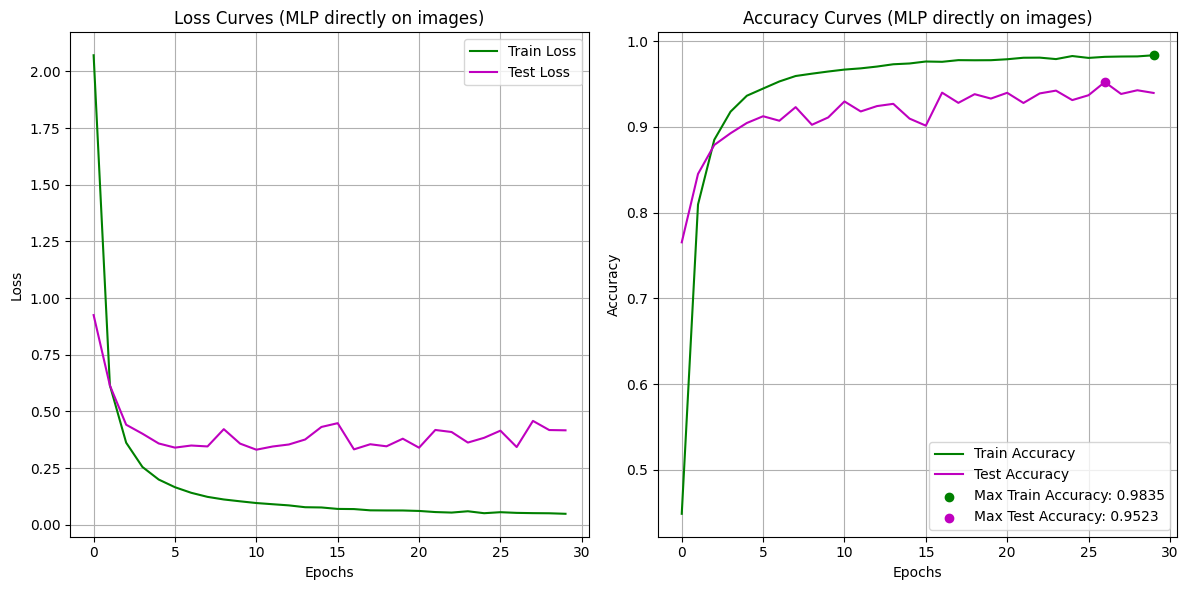

In [181]:
plot_accuracies_and_losses(train_losses_mlp, test_losses_mlp, train_accuracies_mlp, test_accuracies_mlp, "MLP directly on images")

## CNN

In [141]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_transform_augmented = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='./data/fruits-360/Training', transform=train_transform)
train_dataset_augmented = datasets.ImageFolder(root='./data/fruits-360/Training', transform=train_transform_augmented)
test_dataset = datasets.ImageFolder(root='./data/fruits-360/Test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_dataset), len(train_dataset_augmented), len(test_dataset))
print(train_loader.dataset[0][0].shape, train_loader_augmented.dataset[0][0].shape, test_loader.dataset[0][0].shape)

70491 70491 23619
torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) torch.Size([3, 32, 32])


In [142]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3x28x28, Output: 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 32x14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 64x7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output: 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Global Average Pooling
        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Output: 128x1x1
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                # Output: 128
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pooling(x)
        x = self.fc_layers(x)
        return x
    
model = CNN(num_classes=len(np.unique(train_labels)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


In [143]:
# Train with unaugmented images
num_epochs = 20
train_losses_no_aug, test_losses_no_aug, train_accuracies_no_aug, test_accuracies_no_aug = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.53it/s]


Epoch 1/20, Train Loss: 2.3639, Test Loss: 0.7633, Train Acc: 0.4011, Test Acc: 0.8471


Epoch 2/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 26.71it/s]


Epoch 2/20, Train Loss: 0.6897, Test Loss: 0.3271, Train Acc: 0.7953, Test Acc: 0.9131


Epoch 3/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 27.24it/s]


Epoch 3/20, Train Loss: 0.3513, Test Loss: 0.2355, Train Acc: 0.8977, Test Acc: 0.9368


Epoch 4/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 28.26it/s]


Epoch 4/20, Train Loss: 0.2262, Test Loss: 0.1644, Train Acc: 0.9343, Test Acc: 0.9508


Epoch 5/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.65it/s]


Epoch 5/20, Train Loss: 0.1639, Test Loss: 0.1300, Train Acc: 0.9528, Test Acc: 0.9660


Epoch 6/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 26.93it/s]


Epoch 6/20, Train Loss: 0.1287, Test Loss: 0.1013, Train Acc: 0.9623, Test Acc: 0.9710


Epoch 7/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 28.34it/s]


Epoch 7/20, Train Loss: 0.1040, Test Loss: 0.0917, Train Acc: 0.9695, Test Acc: 0.9761


Epoch 8/20 Testing: 100%|██████████| 370/370 [00:16<00:00, 23.12it/s]


Epoch 8/20, Train Loss: 0.0888, Test Loss: 0.0905, Train Acc: 0.9738, Test Acc: 0.9784


Epoch 9/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 25.12it/s]


Epoch 9/20, Train Loss: 0.0748, Test Loss: 0.1122, Train Acc: 0.9788, Test Acc: 0.9713


Epoch 10/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 28.17it/s]


Epoch 10/20, Train Loss: 0.0666, Test Loss: 0.0820, Train Acc: 0.9802, Test Acc: 0.9749


Epoch 11/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 26.06it/s]


Epoch 11/20, Train Loss: 0.0603, Test Loss: 0.1166, Train Acc: 0.9818, Test Acc: 0.9701


Epoch 12/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 28.74it/s]


Epoch 12/20, Train Loss: 0.0556, Test Loss: 0.0993, Train Acc: 0.9835, Test Acc: 0.9739


Epoch 13/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 28.75it/s]


Epoch 13/20, Train Loss: 0.0545, Test Loss: 0.0747, Train Acc: 0.9836, Test Acc: 0.9825


Epoch 14/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 28.45it/s]


Epoch 14/20, Train Loss: 0.0459, Test Loss: 0.0773, Train Acc: 0.9864, Test Acc: 0.9824


Epoch 15/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 28.27it/s]


Epoch 15/20, Train Loss: 0.0438, Test Loss: 0.0701, Train Acc: 0.9868, Test Acc: 0.9815


Epoch 16/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 25.38it/s]


Epoch 16/20, Train Loss: 0.0419, Test Loss: 0.0880, Train Acc: 0.9872, Test Acc: 0.9838


Epoch 17/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 31.40it/s]


Epoch 17/20, Train Loss: 0.0387, Test Loss: 0.1133, Train Acc: 0.9885, Test Acc: 0.9776


Epoch 18/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.46it/s]


Epoch 18/20, Train Loss: 0.0357, Test Loss: 0.0826, Train Acc: 0.9890, Test Acc: 0.9752


Epoch 19/20 Testing: 100%|██████████| 370/370 [00:15<00:00, 23.64it/s]


Epoch 19/20, Train Loss: 0.0372, Test Loss: 0.0732, Train Acc: 0.9886, Test Acc: 0.9849


Epoch 20/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 26.81it/s]

Epoch 20/20, Train Loss: 0.0354, Test Loss: 0.1151, Train Acc: 0.9888, Test Acc: 0.9789


In [144]:
# Train with augmented images

model_aug = CNN(num_classes=len(np.unique(train_labels)))
model_aug = model_aug.to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug = train_model(
    model_aug, train_loader_augmented, test_loader, criterion, optimizer_aug, num_epochs, device
)

Epoch 1/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 31.29it/s]


Epoch 1/20, Train Loss: 1.5855, Test Loss: 0.6999, Train Acc: 0.5457, Test Acc: 0.7703


Epoch 2/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 26.28it/s]


Epoch 2/20, Train Loss: 0.5391, Test Loss: 0.5190, Train Acc: 0.8238, Test Acc: 0.8277


Epoch 3/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 30.24it/s]


Epoch 3/20, Train Loss: 0.3371, Test Loss: 0.2464, Train Acc: 0.8874, Test Acc: 0.9329


Epoch 4/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.62it/s]


Epoch 4/20, Train Loss: 0.2474, Test Loss: 0.2873, Train Acc: 0.9181, Test Acc: 0.9067


Epoch 5/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 27.49it/s]


Epoch 5/20, Train Loss: 0.2074, Test Loss: 0.3905, Train Acc: 0.9300, Test Acc: 0.8733


Epoch 6/20 Testing: 100%|██████████| 370/370 [00:16<00:00, 22.46it/s]


Epoch 6/20, Train Loss: 0.1815, Test Loss: 0.3059, Train Acc: 0.9396, Test Acc: 0.9026


Epoch 7/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.70it/s]


Epoch 7/20, Train Loss: 0.1517, Test Loss: 0.4275, Train Acc: 0.9487, Test Acc: 0.8820


Epoch 8/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.37it/s]


Epoch 8/20, Train Loss: 0.1444, Test Loss: 0.9289, Train Acc: 0.9506, Test Acc: 0.7687


Epoch 9/20 Testing: 100%|██████████| 370/370 [00:15<00:00, 23.36it/s]


Epoch 9/20, Train Loss: 0.1193, Test Loss: 0.2015, Train Acc: 0.9598, Test Acc: 0.9439


Epoch 10/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 33.06it/s]


Epoch 10/20, Train Loss: 0.1096, Test Loss: 0.2155, Train Acc: 0.9636, Test Acc: 0.9364


Epoch 11/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 25.08it/s]


Epoch 11/20, Train Loss: 0.1090, Test Loss: 0.1873, Train Acc: 0.9633, Test Acc: 0.9490


Epoch 12/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 25.04it/s]


Epoch 12/20, Train Loss: 0.0964, Test Loss: 0.1382, Train Acc: 0.9671, Test Acc: 0.9656


Epoch 13/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 25.12it/s]


Epoch 13/20, Train Loss: 0.0947, Test Loss: 0.1393, Train Acc: 0.9671, Test Acc: 0.9671


Epoch 14/20 Testing: 100%|██████████| 370/370 [00:11<00:00, 32.16it/s]


Epoch 14/20, Train Loss: 0.0899, Test Loss: 0.1477, Train Acc: 0.9700, Test Acc: 0.9635


Epoch 15/20 Testing: 100%|██████████| 370/370 [00:15<00:00, 23.29it/s]


Epoch 15/20, Train Loss: 0.0826, Test Loss: 0.1407, Train Acc: 0.9719, Test Acc: 0.9565


Epoch 16/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.65it/s]


Epoch 16/20, Train Loss: 0.0786, Test Loss: 0.1566, Train Acc: 0.9744, Test Acc: 0.9637


Epoch 17/20 Testing: 100%|██████████| 370/370 [00:16<00:00, 21.86it/s]


Epoch 17/20, Train Loss: 0.0740, Test Loss: 0.1171, Train Acc: 0.9745, Test Acc: 0.9696


Epoch 18/20 Testing: 100%|██████████| 370/370 [00:12<00:00, 29.29it/s]


Epoch 18/20, Train Loss: 0.0739, Test Loss: 0.1610, Train Acc: 0.9754, Test Acc: 0.9622


Epoch 19/20 Testing: 100%|██████████| 370/370 [00:14<00:00, 25.70it/s]


Epoch 19/20, Train Loss: 0.0682, Test Loss: 0.1170, Train Acc: 0.9764, Test Acc: 0.9688


Epoch 20/20 Testing: 100%|██████████| 370/370 [00:13<00:00, 26.87it/s]

Epoch 20/20, Train Loss: 0.0651, Test Loss: 0.1527, Train Acc: 0.9780, Test Acc: 0.9646


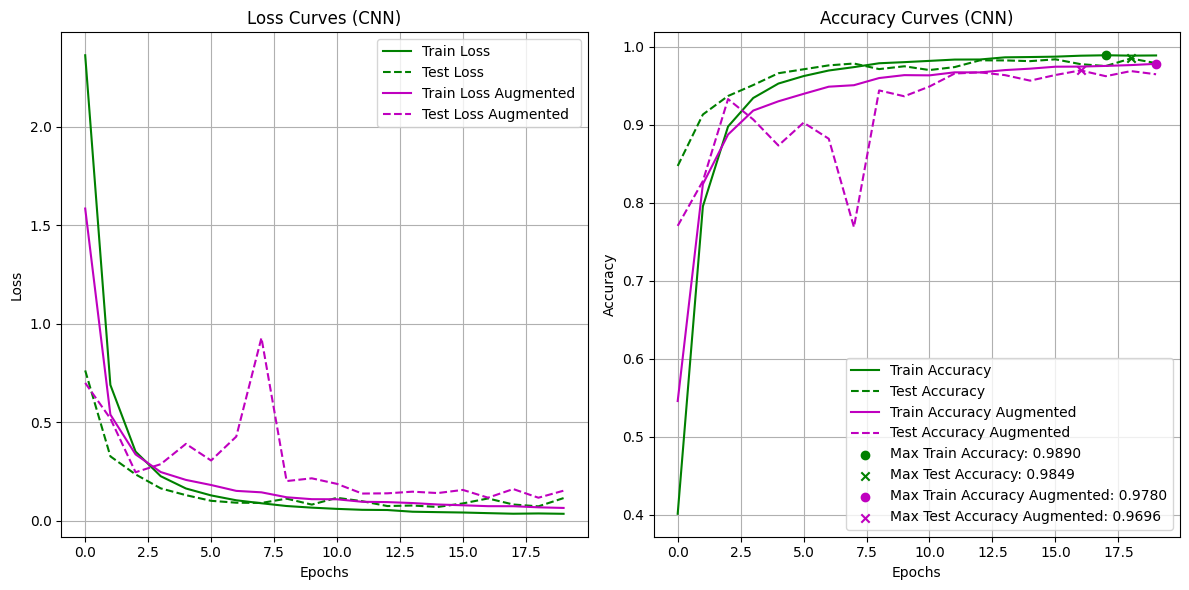

In [154]:
def plot_accuracies_and_losses_2(train_losses, test_losses, train_accuracies, test_accuracies,
                                 train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug, title):
    
    max_train_accuracy = max(train_accuracies)
    max_test_accuracy = max(test_accuracies)
    max_train_epoch = train_accuracies.index(max_train_accuracy)
    max_test_epoch = test_accuracies.index(max_test_accuracy)

    max_train_accuracy_aug = max(train_accuracies_aug)
    max_test_accuracy_aug = max(test_accuracies_aug)
    max_train_epoch_aug = train_accuracies_aug.index(max_train_accuracy_aug)
    max_test_epoch_aug = test_accuracies_aug.index(max_test_accuracy_aug)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    plt.plot(train_losses, label="Train Loss", color='g')
    plt.plot(test_losses, label="Test Loss", color='g', linestyle='--')
    plt.plot(train_losses_aug, label="Train Loss Augmented", color='m')
    plt.plot(test_losses_aug, label="Test Loss Augmented", color='m', linestyle='--')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({title})")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)

    plt.plot(train_accuracies, label="Train Accuracy", color='g')
    plt.plot(test_accuracies, label="Test Accuracy", color='g', linestyle='--')
    plt.plot(train_accuracies_aug, label="Train Accuracy Augmented", color='m')
    plt.plot(test_accuracies_aug, label="Test Accuracy Augmented", color='m', linestyle='--')

    plt.scatter(max_train_epoch, max_train_accuracy, color='g', label=f"Max Train Accuracy: {max_train_accuracy:.4f}", zorder=5)
    plt.scatter(max_test_epoch, max_test_accuracy, color='g', label=f"Max Test Accuracy: {max_test_accuracy:.4f}", zorder=5, marker='x')
    plt.scatter(max_train_epoch_aug, max_train_accuracy_aug, color='m', label=f"Max Train Accuracy Augmented: {max_train_accuracy_aug:.4f}", zorder=5)
    plt.scatter(max_test_epoch_aug, max_test_accuracy_aug, color='m', label=f"Max Test Accuracy Augmented: {max_test_accuracy_aug:.4f}", zorder=5, marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves ({title})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


plot_accuracies_and_losses_2(train_losses_no_aug, test_losses_no_aug, train_accuracies_no_aug, test_accuracies_no_aug,
                                train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug, "CNN")

## Fine-tuning ResNet-18

In [4]:
train_transform_resnet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

test_transform_resnet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

train_dataset_resnet = datasets.ImageFolder(root='./data/fruits-360/Training', transform=train_transform_resnet)
test_dataset_resnet = datasets.ImageFolder(root='./data/fruits-360/Test', transform=test_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=64, shuffle=True)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=64, shuffle=False)

In [9]:
model_resnet18 = resnet18_cifar10(pretrained=True)

num_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_features, len(np.unique(train_labels)))

model_resnet18.fc = nn.Sequential(
    #nn.Linear(num_features, 128),
    #nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(num_features, len(np.unique(train_labels)))
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet18.parameters(), lr=0.0005, momentum=0.9)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.1)


In [10]:
def train_resnet(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

            

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        scheduler.step()

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))

        

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [11]:
num_epochs = 10
train_losses_resnet, test_losses_resnet, train_accuracies_resnet, test_accuracies_resnet = train_resnet(
    model_resnet18, train_loader_resnet, test_loader_resnet, criterion, optimizer_resnet, scheduler_resnet, num_epochs, device
)

Epoch 1/10 Testing: 100%|██████████| 370/370 [00:19<00:00, 18.65it/s]


Epoch 1/10, Train Loss: 4.1813, Test Loss: 3.5505, Train Acc: 0.1709, Test Acc: 0.2486


Epoch 2/10 Testing: 100%|██████████| 370/370 [00:19<00:00, 19.41it/s]


Epoch 2/10, Train Loss: 2.8924, Test Loss: 2.2178, Train Acc: 0.4069, Test Acc: 0.6331


Epoch 3/10 Testing: 100%|██████████| 370/370 [00:26<00:00, 13.99it/s]


Epoch 3/10, Train Loss: 1.3005, Test Loss: 0.6273, Train Acc: 0.8763, Test Acc: 0.9669


Epoch 4/10 Testing: 100%|██████████| 370/370 [00:17<00:00, 21.15it/s]


Epoch 4/10, Train Loss: 0.2816, Test Loss: 0.1982, Train Acc: 0.9962, Test Acc: 0.9840


Epoch 5/10 Testing: 100%|██████████| 370/370 [00:22<00:00, 16.36it/s]


Epoch 5/10, Train Loss: 0.0943, Test Loss: 0.1284, Train Acc: 1.0000, Test Acc: 0.9845


Epoch 6/10 Testing: 100%|██████████| 370/370 [00:23<00:00, 15.77it/s]


Epoch 6/10, Train Loss: 0.0638, Test Loss: 0.1224, Train Acc: 1.0000, Test Acc: 0.9854


Epoch 7/10 Testing: 100%|██████████| 370/370 [00:18<00:00, 19.70it/s]


Epoch 7/10, Train Loss: 0.0604, Test Loss: 0.1188, Train Acc: 1.0000, Test Acc: 0.9842


Epoch 8/10 Testing: 100%|██████████| 370/370 [00:19<00:00, 18.70it/s]


Epoch 8/10, Train Loss: 0.0576, Test Loss: 0.1156, Train Acc: 1.0000, Test Acc: 0.9852


Epoch 9/10 Testing: 100%|██████████| 370/370 [00:20<00:00, 18.16it/s]


Epoch 9/10, Train Loss: 0.0547, Test Loss: 0.1163, Train Acc: 1.0000, Test Acc: 0.9849


Epoch 10/10 Testing: 100%|██████████| 370/370 [00:19<00:00, 18.79it/s]

Epoch 10/10, Train Loss: 0.0522, Test Loss: 0.1128, Train Acc: 1.0000, Test Acc: 0.9856


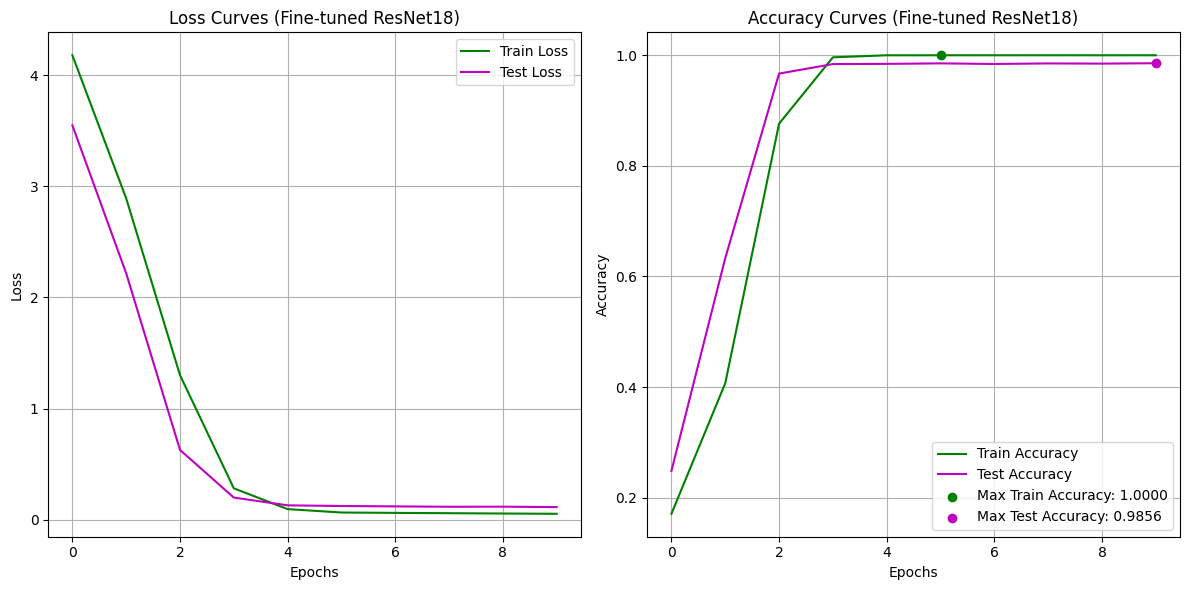

In [14]:
plot_accuracies_and_losses(train_losses_resnet, test_losses_resnet, train_accuracies_resnet, test_accuracies_resnet, "Fine-tuned ResNet18")